In [1]:
from __future__ import division 
from scipy.interpolate import InterpolatedUnivariateSpline #一维插值函数
from scipy.optimize import fminbound #求其最小值的函数，返回其最小值点
import matplotlib.pyplot as plt #绘图
import numpy as np
from scipy.optimize import fsolve
import random as rd
from scipy.optimize import bisect

$$
\begin{aligned}
&\max _{\left\{c_{t}\right\}_{t}^{\infty}=0} \mathrm{E}\left\{\sum_{t=0}^{\infty}  \beta^{t} \mu\left(c_{t}\right)\right\} \\
&\text { s.t } c_{t}+k_{t+1}=f\left(A_{t}, k_{t}\right)+(1-\delta) k_{t}, \forall t=0,1,2, \cdots
\end{aligned}
$$
$$
\begin{aligned}
&f\left(A_{t}, k_{t}\right)=\left\{\begin{array}{l}
f^{H}\left(A_{t}, k_{t}\right)=\alpha A_{t} k_{t}^{\gamma H}-\underline f, k_{t}>\tilde{k} \\
f^{L}\left(A_{t}, k_{t}\right)=\alpha A_{t} k_{t}^{\gamma L}， k_{t} \leqslant \tilde{k}
\end{array}\right. \\
&\tilde{k}=\left\{k \mid f^{H}\left(A_{t}, k_{t}\right)=f^{\mathrm{L}}\left(A_{t}, k_{t}\right)\right\}
\end{aligned}
$$

In [2]:
class DP(object):
    def __init__(self, beta = 0.98, delta = 0.1,gammaH = 0.5,gammaL = 0.1,alpha = 1,underf = 1,
                 transition = [[0.9,0.1],[0.9,0.1]],shocks = [1,0.1],#初始化
        grid_max=25, grid_min = 0.05, grid_size=1000):
        self.delta, self.beta ,self.gammaH,self.gammaL,self.alpha, self.underf = delta, beta,gammaH,gammaL,alpha, underf#变量初始化，具体说明见题意
        self.shocks = shocks
        self.u = np.log
        self.transition = np.asarray(transition)
        func0 = lambda k: self.alpha*self.shocks[0]*k**self.gammaH -self.underf - self.alpha*self.shocks[0]*k**self.gammaL
        func1 = lambda k: self.alpha*self.shocks[1]*k**self.gammaH -self.underf - self.alpha*self.shocks[1]*k**self.gammaL
        self.tildek = [fsolve(func0,x0 = 1),fsolve(func1,x0 = 1)]
    
        



        for j in range(len(self.transition)):
            self.transition[j] = [max(k, 0) for k in self.transition[j]]
            self.transition[j] /= np.asarray(list(self.transition[j])).sum()
            if np.asarray(self.transition[j]).sum() == 0:
                self.transition[j] = np.asarray([1/len(self.transition)]*len(self.transition))
        self.transition = np.asarray(self.transition)

        self.grid = np.linspace(grid_min, grid_max, grid_size)#生成插值点
    
    
    def f(self,j,a,k):
        if k > self.tildek[j]:
            return self.alpha*a*k**self.gammaH-self.underf
        else:
            return self.alpha*a*k**self.gammaL
    
#         return max(self.alpha*a*k**self.gammaH-self.underf,self.alpha*a*k**self.gammaL)

    def bellman_operator(self, w):#定义贝尔曼方程，用于后面的迭代求解
        Aw = [InterpolatedUnivariateSpline(self.grid, w[i]) for i in range(len(self.shocks))]
        Awx = lambda y: np.asarray([function(y) for function in Aw])
        sigma = np.asarray([np.empty(len(w[0]))]*len(self.shocks))
        c = np.asarray([np.empty(len(w[0]))]*len(self.shocks))
        Tw = np.asarray([np.empty(len(w[0]))]*len(self.shocks))
       
        for i, k in enumerate(self.grid):
                for j, a in enumerate(self.shocks):
                    func = self.f(j,a,k)
                    objective = lambda c: -self.u(c)-self.beta*np.dot(self.transition[j],Awx(func+(1-self.delta)*k-c))
                    c_star = fminbound(objective,1e-6,func+(1-self.delta)*k)
                    Tw[j][i] = - objective(c_star)
                    c[j][i] = c_star
                    sigma[j][i] = func+(1-self.delta)*k-c_star
                    
        return Tw,sigma,c

In [3]:
def compute_fixed_point(T, v, error_tol=1e-3, max_iter=500,
                            print_skip=25,verbose=True):#迭代计算
        i = 0
        error = error_tol + 1

        while i < max_iter and error > error_tol:
            new_v = T(v)[0]
            i += 1
            error = np.max(np.abs(new_v - v))
            if verbose and i % print_skip == 0:
                print(f"第 {i}步收敛结果是  {error}.")
                
            v = new_v
        if i == max_iter:
            print("收敛失败")
        if verbose and i < max_iter:
            print(f"\n在第 {i} 步收敛")


        return v

In [4]:
problem = DP()

v = np.asarray([np.zeros(problem.grid.size)]*len(problem.shocks))
v_star = compute_fixed_point(problem.bellman_operator, v, max_iter = 500, verbose = 1)

第 25步收敛结果是  0.153934170381115.
第 50步收敛结果是  0.12124675714586086.
第 75步收敛结果是  0.05643169630793343.
第 100步收敛结果是  0.03381677043431708.
第 125步收敛结果是  0.038175501921168475.
第 150步收敛结果是  0.04496183681110466.
第 175步收敛结果是  0.010516330495375037.
第 200步收敛结果是  0.03076020104654731.
第 225步收敛结果是  0.030676081897687446.
第 250步收敛结果是  0.001633215463209936.
第 275步收敛结果是  0.0009855879281817082.

在第 275 步收敛


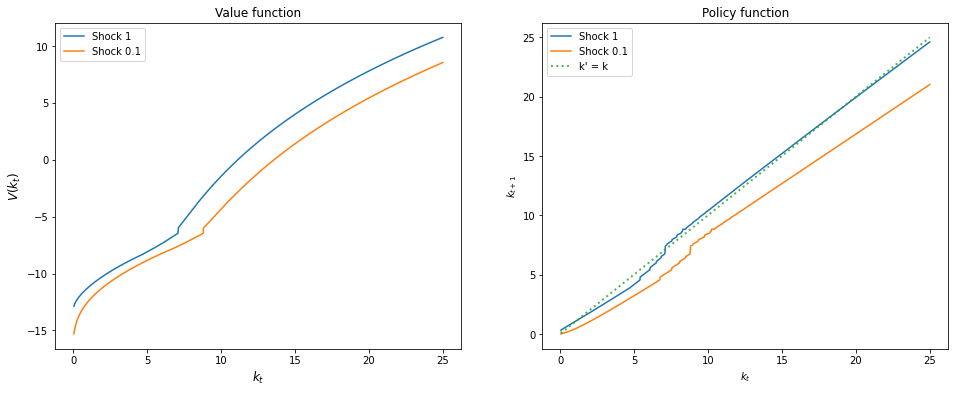

In [5]:
fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
labels = [r'Shock {0:.2g}'.format(problem.shocks[k]) for k in range(len(problem.shocks))]
ax1.plot(problem.grid, v_star[0], label=labels[0])
ax1.plot(problem.grid, v_star[1], label=labels[1])
ax1.set_ylabel('$V(k_{t})$', fontsize=12)
ax1.set_xlabel('$k_{t}$', fontsize=12)
ax1.set_title('Value function')
ax1.legend()

sigma_star = problem.bellman_operator(v_star)[1]
ax2.plot(problem.grid, sigma_star[0], label=labels[0])
ax2.plot(problem.grid, sigma_star[1], label=labels[1])
ax2.plot(problem.grid,problem.grid, alpha = .8, lw = 2,  label= "k' = k",linestyle=":")
ax2.set_ylabel(r'$k_{t+1}$')
ax2.set_xlabel('$k_{t}$')
ax2.legend()
ax2.set_title('Policy function')
plt.show()

In [195]:
sigma = [InterpolatedUnivariateSpline(problem.grid,sigma_star[i] ) for i in range(len(problem.shocks))]
func = lambda x: sigma[0](x)-x
trapk = fsolve(func,x0 = 7.09)
trapk

array([7.10438501])

In [166]:
a = sigma_star[0]-problem.grid
for i,j in enumerate(a):
    if a[i] < 0 and a[i+1] > 0:
        print(problem.grid[i],problem.grid[i+1])
        break

7.092942942942942 7.117917917917917


In [21]:
def simulation(problem,k0,T):
    sigma = [InterpolatedUnivariateSpline(problem.grid,sigma_star[i] ) for i in range(len(problem.shocks))]
    trans = problem.transition
    ident = np.array(trans)
    for i in range (0,2):
        for j in range (1,2):
            ident[i][j] = trans[i][j] + ident[i][j-1]
    n = 0
    kk = np.zeros(T+1)
    state = np.zeros(T+1)
    state[0] = 0
    
    plt.figure(figsize = (10,8))
    for p in range(len(k0)):
        kk[0] = k0[p]
        for i in range(0,T):
            flag = rd.random()
            for j in range(0,2):
                if flag < ident[int(state[i])][j]:
                    kk[i+1] = sigma[j](kk[i])
                    state[i+1] = j
                    break

        caplab = r'k0 = {0:.2f}'.format(k0[p])          
        plt.plot(np.arange(0,T+1),kk,label = caplab, alpha = .8, lw = 2)
    
    plt.legend(loc = 'lower right')
    plt.show()

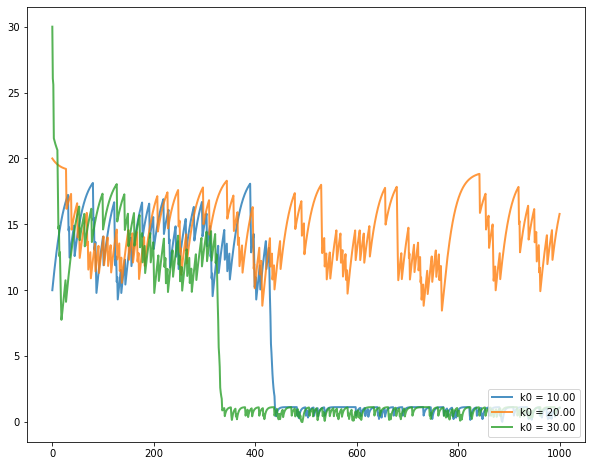

In [22]:
simulation(problem,[10,20,30],1000)

In [253]:
def simulation(problem,k0,T,times):
    prob = np.zeros(times)
    trans = problem.transition
    ident = np.array(trans)
    for i in range (0,2):
        for j in range (1,2):
            ident[i][j] = trans[i][j] + ident[i][j-1]
    for m in range(0,times):
        n = 0
        kk = np.zeros(T+1)
        state = np.zeros(T+1)
        state[0] = 0
        kk[0] = k0
        for i in range(0,T):
            flag = rd.random() 
            for j in range(0,2):
                if flag < ident[int(state[i])][j]:
                    kk[i+1] = sigma[j](kk[i])
                    state[i+1] = j
                    if kk[i+1] < 7.1:
                        n = n+1
                    break
        prob[m] = n/T

    return np.mean(prob)
                    
#     plt.figure(figsize = (10,8))                
#     plt.plot(np.arange(0,T+1),kk, alpha = .8, lw = 2)
    
#     plt.show()

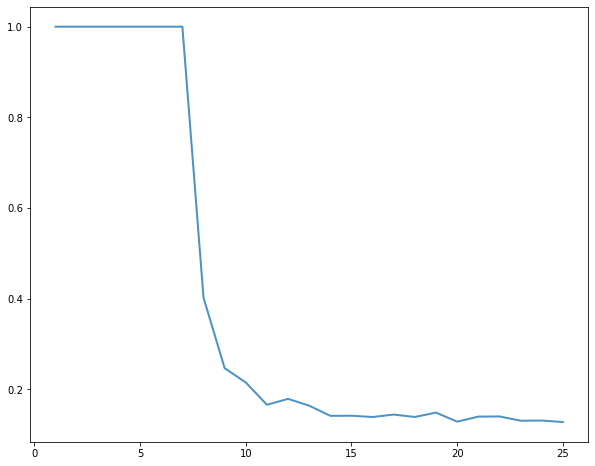

In [290]:
prob = np.zeros(25)
for i in range(0,25):
    prob[i] =  simulation(problem,i+1,500,1000)

    
plt.figure(figsize = (10,8))                
plt.plot(np.arange(1,26),prob, alpha = .8, lw = 2)

plt.show()

$$
\begin{aligned}
&\max _{\left\{c_{t}\right\}_{t}^{\infty}=0} \mathrm{E}\left\{\sum_{t=0}^{\infty} \beta^{t} \mu\left(c_{t}\right)\right\} \\
&\text { s. t. }\left\{\begin{array}{l}
C_{0}+K_{1}+\frac{M}{N}+M r=f\left(A_{t}, K_{0}+M\right)+(1-\delta)\left(K_{0}+M\right), t=0 \\
C_{t}+K_{t+1}+\frac{M}{N}+\frac{N-t}{N} M r=f\left(A_{t}, K_{t}\right)+(1-\delta) K_{t}, 0<t \leqslant N \\
C_{t}+K_{t+1}=f\left(A_{t}, K_{t}\right)+(1-\delta) K_{t}, t>N
\end{array}\right.
\end{aligned}
$$